<a href="https://colab.research.google.com/github/aeldably/Neural_Data_Science_Summer_2025/blob/lab7-aakarsh/notebooks/CodingLab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>Aakarsh Nair, Andreas Kotzur, Ahmed Eldably</span>

LLM Disclaimer: <span style='background: yellow'>Google Gemini , Google Gemini Diffiusion - Planning, Coding, and Verification.</span>

# Coding Lab 7 : Transcriptomics

In [1]:
import os
import subprocess

if os.environ.get("COLAB_JUPYTER_IP"):
    if os.path.exists("/content/Neural_Data_Science_Summer_2025/"):
        os.chdir("/content/Neural_Data_Science_Summer_2025/")
    else:
        # Use subprocess.run to execute the git clone command
        subprocess.run(["git", "clone", "https://github.com/aeldably/Neural_Data_Science_Summer_2025/"])
    os.chdir("Neural_Data_Science_Summer_2025/notebooks")
    print("This code runs only in Colab")
else:
    print("This code runs outside of Colab")


This code runs only in Colab


In [2]:
!pip3 install tsnecuda==3.0.1+cu122 -f https://tsnecuda.isx.ai/tsnecuda_stable.html
!pip install openTSNE jupyter_black watermark igraph leidenalg

Looking in links: https://tsnecuda.isx.ai/tsnecuda_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.6/385.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt

# We recommend using openTSNE for experiments with t-SNE
# https://github.com/pavlin-policar/openTSNE
from openTSNE import TSNE

#%matplotlib inlinep

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-06-07 16:48:40UTC

Python implementation: CPython
Python version       : 3.11.13
IPython version      : 7.34.0

sklearn: 1.6.1

pandas    : 2.2.2
openTSNE  : 1.0.2
numpy     : 2.0.2
matplotlib: 3.10.0

Watermark: 2.5.0



In [4]:
plt.style.use("../matplotlib_style.txt")

# Introduction

In this notebook you are going to work with transcriptomics data, in particular single-cell RNA sequencing (scRNA-seq) data from the paper by [Harris et al. (2018)](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387). They recorded the transcriptomes of 3,663 inhibitory cells in the hippocampal area CA1. Their analysis divided these cells into 49 fine-scale clusters coresponding to different cell subtypes. They asigned names to these cluster in a hierarchical fashion according to strongly expressed gene in each clusters. The figure below shows the details of their classification.

You will first analyze some of the most relevant statistics of UMI gene counts distributions, and afterwards follow the standard pipeline in the field to produce a visualization of the data.

## Load data

Download the data from ILIAS, move it to the `data/` directory and unzip it there.
The read counts can be found in `counts`, with rows corresponding to cells and columns to genes.
The cluster assignments for every individual cell can be found in  `clusters`, along with the colors used in the publication in  `clusterColors`.

In [5]:
# LOAD HARRIS ET AL DATA

# Load gene counts
data = pd.read_csv("../data/nds_cl_7/harris-data/expression.tsv", sep="\t")
genes = data.values[:, 0]
cells = data.columns[1:-1]
counts = data.values[:, 1:-1].transpose().astype("int")
data = []

# Kick out all genes with all counts = 0
genes = genes[counts.sum(axis=0) > 0]
counts = counts[:, counts.sum(axis=0) > 0]
print(counts.shape)

# Load clustering results
data = pd.read_csv("../data/nds_cl_7/harris-data/analysis_results.tsv", sep="\t")
clusterNames, clusters = np.unique(data.values[0, 1:-1], return_inverse=True)

# Load cluster colors
data = pd.read_csv("../data/nds_cl_7/harris-data/colormap.txt", sep="\s+", header=None)
clusterColors = data.values

# Note: the color order needs to be reversed to match the publication
clusterColors = clusterColors[::-1]

# Taken from Figure 1 - we need cluster order to get correct color order
clusterOrder = [
    "Sst.No",
    "Sst.Npy.C",
    "Sst.Npy.Z",
    "Sst.Npy.S",
    "Sst.Npy.M",
    "Sst.Pnoc.Calb1.I",
    "Sst.Pnoc.Calb1.P",
    "Sst.Pnoc.P",
    "Sst.Erbb4.R",
    "Sst.Erbb4.C",
    "Sst.Erbb4.T",
    "Pvalb.Tac1.N",
    "Pvalb.Tac1.Ss",
    "Pvalb.Tac1.Sy",
    "Pvalb.Tac1.A",
    "Pvalb.C1ql1.P",
    "Pvalb.C1ql1.C",
    "Pvalb.C1ql1.N",
    "Cacna2d1.Lhx6.R",
    "Cacna2d1.Lhx6.V",
    "Cacna2d1.Ndnf.N",
    "Cacna2d1.Ndnf.R",
    "Cacna2d1.Ndnf.C",
    "Calb2.Cry",
    "Sst.Cry",
    "Ntng1.S",
    "Ntng1.R",
    "Ntng1.C",
    "Cck.Sema",
    "Cck.Lmo1.N",
    "Cck.Calca",
    "Cck.Lmo1.Vip.F",
    "Cck.Lmo1.Vip.C",
    "Cck.Lmo1.Vip.T",
    "Cck.Ly",
    "Cck.Cxcl14.Calb1.Tn",
    "Cck.Cxcl14.Calb1.I",
    "Cck.Cxcl14.S",
    "Cck.Cxcl14.Calb1.K",
    "Cck.Cxcl14.Calb1.Ta",
    "Cck.Cxcl14.V",
    "Vip.Crh.P",
    "Vip.Crh.C1",
    "Calb2.Vip.G",
    "Calb2.Vip.I",
    "Calb2.Vip.Nos1",
    "Calb2.Cntnap5a.R",
    "Calb2.Cntnap5a.V",
    "Calb2.Cntnap5a.I",
]

reorder = np.zeros(clusterNames.size) * np.nan
for i, c in enumerate(clusterNames):
    for j, k in enumerate(clusterOrder):
        if c[: len(k)] == k:
            reorder[i] = j
            break
clusterColors = clusterColors[reorder.astype(int)]

(3663, 17965)


# Task 1: Data inspection
Before we use t-SNE or any other advanced visualization methods on the data, we first want to have a closer look on the data and plot some statistics. For most of the analysis we will compare the data to a Poisson distribution.

###  1.1. Relationship between expression mean and fraction of zeros
Compute actual and predicted gene expression. The higher the average expression of a gene, the smaller fraction of cells will show a 0 count. Plot the data and explain what you see in the plot.


_(3 pts)_

In [6]:
# ------------------------------------------------------
# Compute actual and predicted gene expression (1 pt)
# ------------------------------------------------------

# Compute the average expression for each gene
mean_expression = np.mean(counts, axis=0)

# Compute the fraction of zeros for each gene
fraction_zeros = np.mean(counts == 0, axis=0)

In [7]:
# Compute the Poisson prediction
# (what is the expected fraction of zeros in a Poisson distribution with a given mean?)
poisson_prediction = np.exp(-mean_expression)

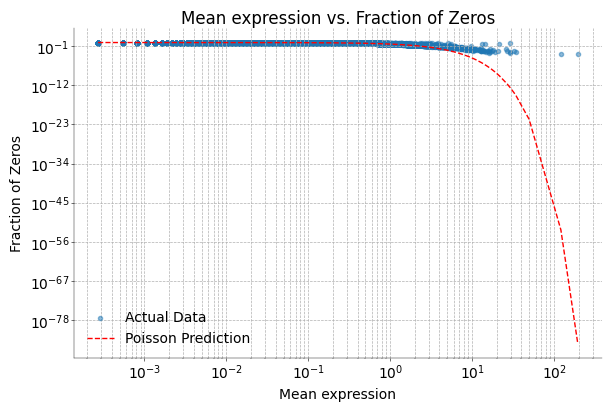

In [8]:
# --------------------------------------------------
# plot the data and the Poisson prediction (1 pt)
# --------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
# add plot

# 1. Plot the actual data as a scatter plot
ax.scatter(mean_expression, fraction_zeros, alpha=0.5, label="Actual Data")

# 2. Plot the Poisson prediction as a line plot
#    (Sorting the values makes the line clean)
sorted_indices = np.argsort(mean_expression)
ax.plot(
    mean_expression[sorted_indices],
    poisson_prediction[sorted_indices],
    color="red",
    linestyle="--",
    label="Poisson Prediction",
)

# 3. Set scales and labels
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Mean expression")
ax.set_ylabel("Fraction of Zeros")
ax.set_title("Mean expression vs. Fraction of Zeros")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend()

plt.savefig("../images/lab7-mean_vs_fraction_zeros.png", dpi=300, bbox_inches="tight")
plt.show()

_Explanation (1 pt)_
...

### 1.2. Mean-variance relationship

If the expression follows Poisson distribution, then the mean should be equal to the variance. Plot the mean-variance relationship and interpret the plot.

_(2.5 pts)_

In [9]:
# -------------------------------------------------------------------
# Compute the variance of the expression counts of each gene (0.5 pt)
# -------------------------------------------------------------------
variance = np.var(counts, axis=0)

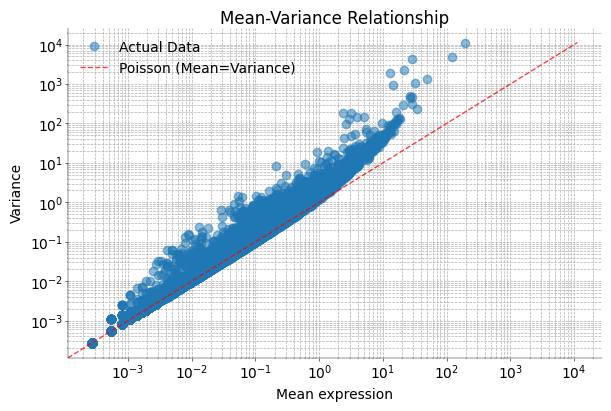

In [10]:
# -------------------------------------------------------------
# Plot the mean-variance relationship on a log-log plot (1 pt)
# Plot the Poisson prediction as a line
# -------------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(mean_expression, variance, "o", alpha=0.5, label="Actual Data")
lims = [
    np.min([plt.xlim(), plt.ylim()]),  # find the min of the axes
    np.max([plt.xlim(), plt.ylim()]),  # find the max of the axes
]
# Plot the y=x line
plt.plot(lims, lims, "r--", alpha=0.75, label="Poisson (Mean=Variance)")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean expression")
plt.ylabel("Variance")
plt.title("Mean-Variance Relationship")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.savefig("../images/lab7-mean_vs_variance.png", dpi=300, bbox_inches="tight")
plt.show()

_Explanation (1 pt)_
...

### 1.3. Relationship between the mean and the Fano factor

Compute the Fano factor for each gene and make a scatter plot of expression mean vs. Fano factor in log-log coordinates, and interpret what you see in the plot. If the expression follows the Poisson distribution, then the Fano factor (variance/mean) should be equal to 1 for all genes.

_(2.5 pts)_

In [11]:
# --------------------------------------------
# Compute the Fano factor for each gene (0.5 pt)
# --------------------------------------------

fano = np.var(counts, axis=0) / np.mean(counts, axis=0)

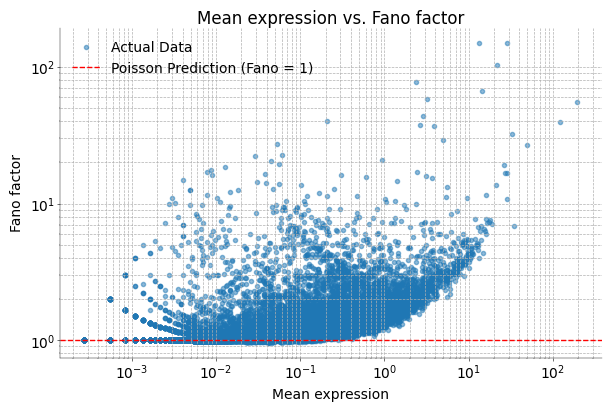

In [12]:
# -------------------------------
# plot fano-factor vs mean (1 pt)
# incl. fano factor
# -------------------------------
# Plot a Poisson prediction as line
# Use the same style of plot as above.

fig, ax = plt.subplots(figsize=(6, 4))

plt.scatter(mean_expression, fano, alpha=0.5, label="Actual Data")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean expression")
plt.ylabel("Fano factor")
plt.title("Mean expression vs. Fano factor")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.axhline(y=1, color="red", linestyle="--", label="Poisson Prediction (Fano = 1)")
plt.legend()
plt.savefig("../images/lab7-mean_vs_fano.png", dpi=300, bbox_inches="tight")
plt.show()

_Explanation (1 pt)_
...

### 1.4. Histogram of sequencing depths

Different cells have different sequencing depths (sum of counts across all genes) because the efficiency can change from droplet to droplet due to some random expreimental factors. Make a histogram of sequencing depths.

_(1.5 pts)_

In [13]:
# -------------------------------
# Compute sequencing depth (0.5 pt)
# -------------------------------
sequencing_depths = np.sum(counts, axis=1)

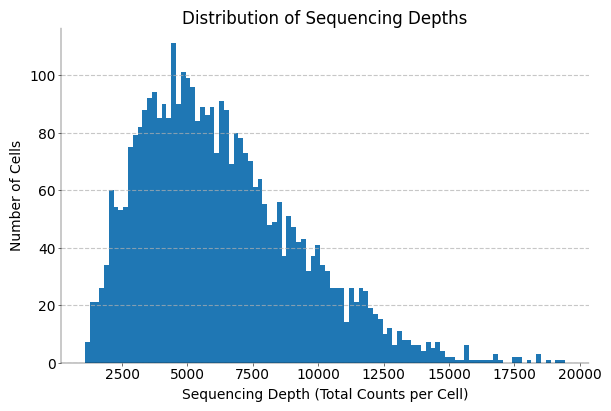

In [14]:
# ------------------------------------------
# Plot histogram of sequencing depths (1 pt)
# ------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

# Create the histogram
ax.hist(sequencing_depths, bins=100)

# Add labels and a title for clarity
ax.set_xlabel("Sequencing Depth (Total Counts per Cell)")
ax.set_ylabel("Number of Cells")
ax.set_title("Distribution of Sequencing Depths")
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig(
    "../images/lab7-sequencing_depth_histogram.png", dpi=300, bbox_inches="tight"
)
plt.show()

### 1.5. Fano factors after normalization

Normalize counts by the sequencing depth of each cell and multiply by the median sequencing depth. Then make the same expression vs Fano factor plot as above. After normalization by sequencing depth, Fano factor should be closer to 1 (i.e. variance even more closely following the mean). This can be used for feature selection.

_(2.5 pts)_

In [15]:
# -------------------------------------------------
# compute normalized counts and fano factor (1 pt)
# -------------------------------------------------
median_depth = np.median(sequencing_depths)

normalized_counts = counts / sequencing_depths[:, np.newaxis] * median_depth
mean_normalized = np.mean(normalized_counts, axis=0)
variance_normalized = np.var(normalized_counts, axis=0)

fano_normalized = variance_normalized / mean_normalized

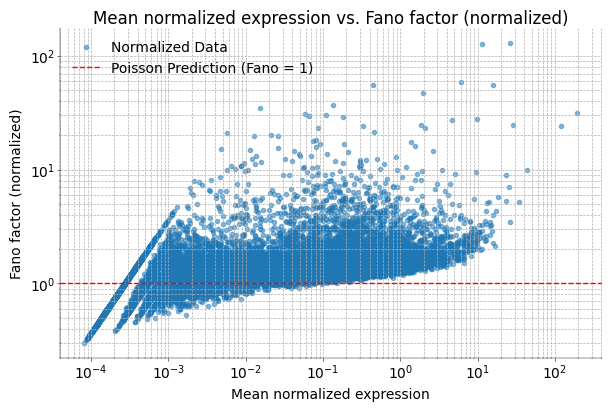

In [16]:
# ----------------------------------------------------------
# plot normalized counts and find the top 10 genes (1 pt)
# hint: keep appropriate axis scaling in mind
# ----------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
# add plot
plt.scatter(mean_normalized, fano_normalized, alpha=0.5, label="Normalized Data")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean normalized expression")
plt.ylabel("Fano factor (normalized)")
plt.title("Mean normalized expression vs. Fano factor (normalized)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.axhline(y=1, color="red", linestyle="--", label="Poisson Prediction (Fano = 1)")
plt.legend()
plt.savefig("../images/lab7-mean_vs_fano_normalized.png", dpi=300, bbox_inches="tight")
plt.show()

In [17]:
# --------------------------------------------------------------------
# Find top-10 genes with the highest normalized Fano factor (0.5 pts)
# Print them sorted by the Fano factor starting from the highest
# Gene names are stored in the `genes` array
# --------------------------------------------------------------------
sorted_indices = np.argsort(fano_normalized)
top_10_indices = sorted_indices[-10:]

top_10_genes = genes[top_10_indices]

print("Top 10 genes with the highest normalized Fano factor:")
print(top_10_genes[::-1])  # [::-1] reverses the list to show highest first

Top 10 genes with the highest normalized Fano factor:
['Sst' 'Npy' 'Vip' 'Cck' 'Cpne2' 'Pcp4' 'Ptpn23' 'Pdzd9' 'Malat1' 'Armc2']


# Task 2: Low dimensional visualization

In this task we will construct a two dimensional visualization of the data. First we will normalize the data with some variance stabilizing transformation and study the effect that different approaches have on the data. Second, we will reduce the dimensionality of the data to a more feasible number of dimensions (e.g. $d=50$) using PCA. And last, we will project the PCA-reduced data to two dimensions using t-SNE.

### 2.1. PCA with and without transformations

Here we look at the influence of variance-stabilizing transformations on PCA. We will focus on the following transformations:
- Square root (`sqrt(X)`): it is a variance-stabilizing transformation for the Poisson data.
- Log-transform (`log2(X+1)`): it is also often used in the transcriptomic community.

We will only work with the most important genes. For that, transform the counts into normalized counts (as above) and select all genes with normalized Fano factor above 3 and remove the rest. We will look at the effect that both transformations have in the PCA-projected data by visualizing the first two components. Interpret qualitatively what you see in the plot and compare the different embeddings making use of the ground truth clusters.

_(3.5 pts)_

In [18]:
# --------------------------------
# Select important genes (0.5 pts)
# --------------------------------


highly_variable_mask = fano_normalized > 3
filtered_counts = normalized_counts[:, highly_variable_mask]

sqrt_transformed_counts = np.sqrt(filtered_counts)
log_transformed_counts = np.log2(filtered_counts + 1)

from sklearn.decomposition import PCA

In [19]:
# --------------------------------------
# transform data and apply PCA (1 pt)
# --------------------------------------

from sklearn.decomposition import PCA

# perform PCA

# Initialize PCA to find the top 50 components
pca = PCA(n_components=50)

# Apply PCA to each of the three datasets
pca_raw = pca.fit_transform(filtered_counts)
pca_sqrt = pca.fit_transform(sqrt_transformed_counts)
pca_log = pca.fit_transform(log_transformed_counts)

pca_results = [pca_raw, pca_sqrt, pca_log]
titles = ["Normalized Counts (Raw)", "Square Root Transform", "Log2(X+1) Transform"]

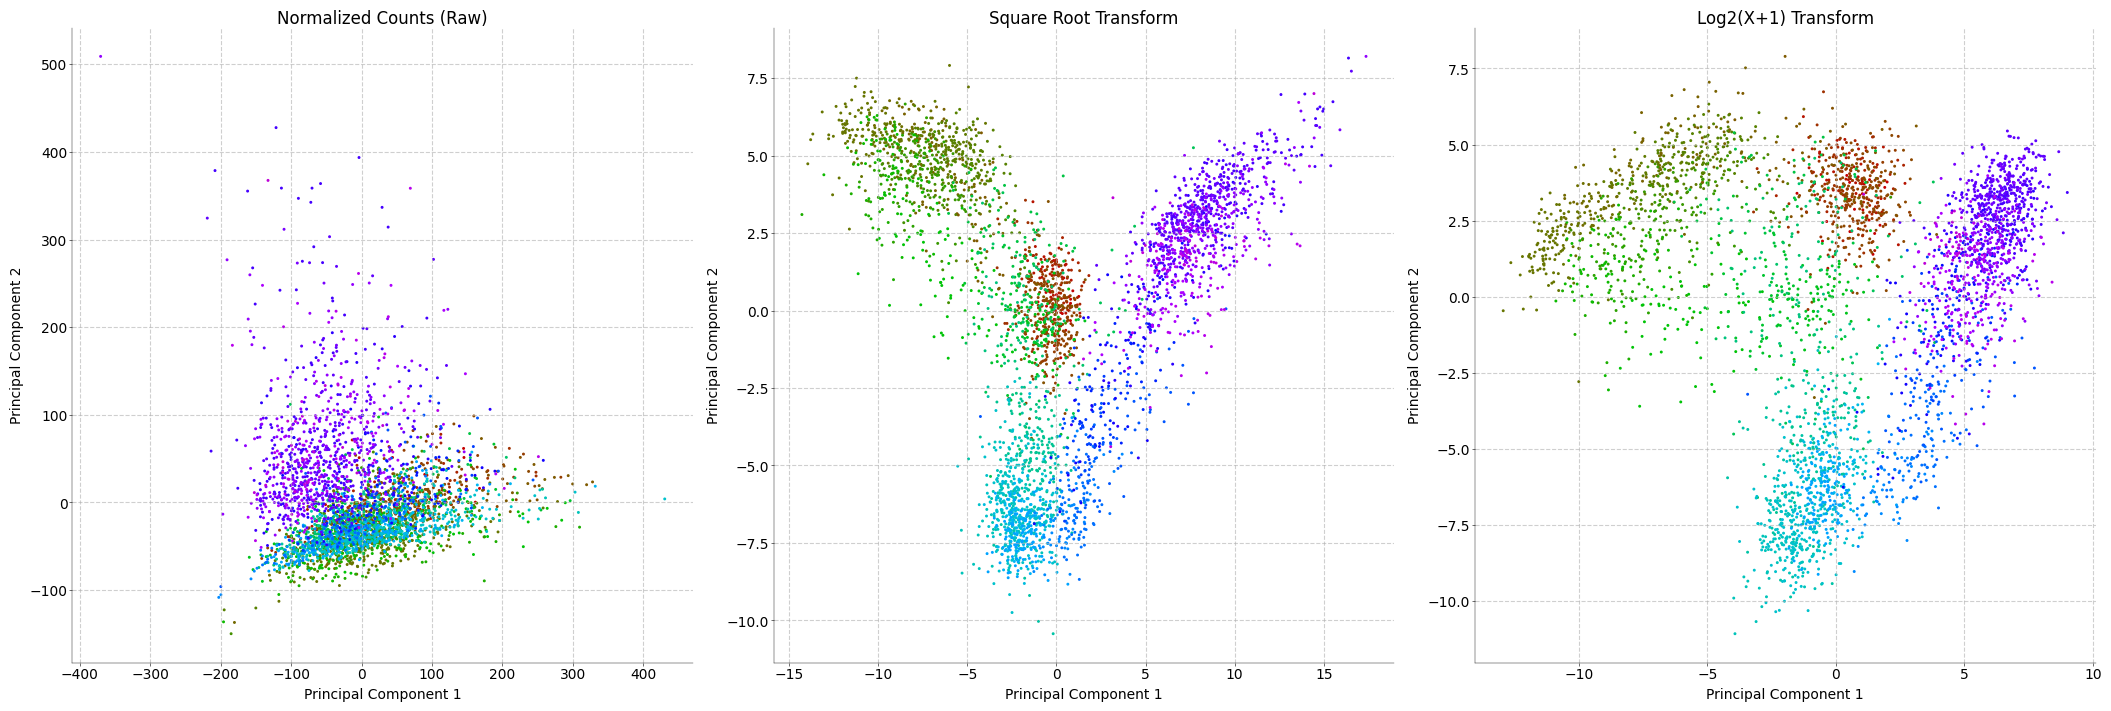

In [20]:
# ------------------------------------------------
# plot first 2 PCs for each transformation (1 pt)
# ------------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(21, 7))
# add plot
for i, (data, title) in enumerate(zip(pca_results, titles)):
    # Scatter plot of the first two principal components
    # c=clusterColors[clusters] assigns the correct publication color to each cell
    axs[i].scatter(data[:, 0], data[:, 1], c=clusterColors[clusters], s=5)

    axs[i].set_title(title)
    axs[i].set_xlabel("Principal Component 1")
    axs[i].set_ylabel("Principal Component 2")
    axs[i].grid(linestyle="--", alpha=0.6)

plt.savefig("../images/lab7-pca_transformations.png", dpi=300, bbox_inches="tight")
plt.show()

_Explanation (1 pt)_
...

### 2.2. tSNE with and without transformations

Now, we will reduce the dimensionality of the PCA-reduced data further to two dimensions using t-SNE. We will use only $n=50$ components of the PCA-projected data. Plot the t-SNE embedding for the three versions of the data and interpret the plots. Do the different transformations have any effect on t-SNE?

_(1.5 pts)_

In [21]:
# -----------------------
# Perform tSNE (0.5 pts)
# -----------------------
from tsnecuda import TSNE


tsne_raw = TSNE(n_components=2, perplexity=30, learning_rate=10).fit_transform(pca_raw)
tsne_sqrt = TSNE(n_components=2, perplexity=30, learning_rate=10).fit_transform(
    pca_sqrt
)
tsne_log = TSNE(n_components=2, perplexity=30, learning_rate=10).fit_transform(pca_log)

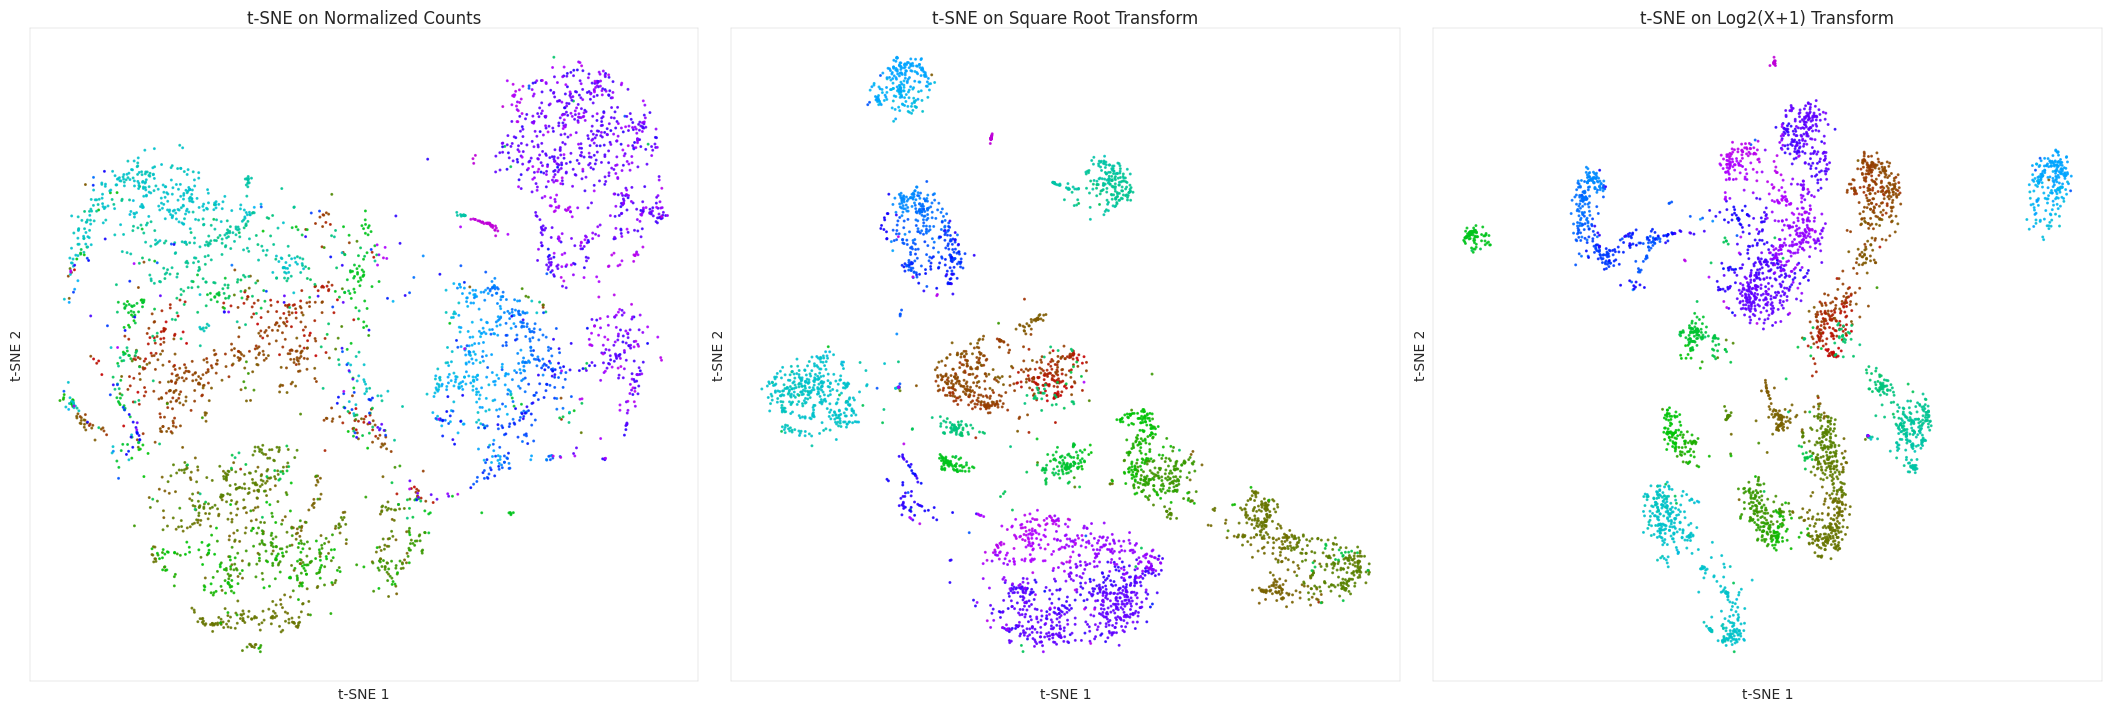

In [27]:
# -----------------------------------------------
# plot t-SNE embedding for each dataset (1 pt)
# -----------------------------------------------
import seaborn as sns

sns.set_style("whitegrid")
# Create a list of t-SNE results and their corresponding titles
tsne_results = [tsne_raw, tsne_sqrt, tsne_log]
titles = [
    "t-SNE on Normalized Counts",
    "t-SNE on Square Root Transform",
    "t-SNE on Log2(X+1) Transform",
]

fig, axs = plt.subplots(1, 3, figsize=(21, 7))
# Loop through each t-SNE result and plot it
for i, (data, title) in enumerate(zip(tsne_results, titles)):
    # Create a scatter plot of the 2D t-SNE data
    # Color each point by its ground-truth cluster identity
    axs[i].scatter(data[:, 0], data[:, 1], c=clusterColors[clusters], s=5, alpha=0.8)

    # Set the title and labels
    axs[i].set_title(title)
    axs[i].set_xlabel("t-SNE 1")
    axs[i].set_ylabel("t-SNE 2")

    # The axes on a t-SNE plot don't have a direct interpretation,
    # so we can remove the tick marks for a cleaner look.
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.savefig("../images/lab7-tsne_transformations.png", dpi=300, bbox_inches="tight")
plt.show()

### 2.3. Leiden clustering

Now we will play around with some clustering and see whether the clustering methods can produce similar results to the original clusters from the publication. We will apply Leiden clustering (closely related to the Louvain clustering), which is standard in the field and works well even for very large datasets.

Choose one representation of the data (best transformation based in your results from the previous task) to use further in this task and justify your choice. Think about which level of dimensionality would be sensible to use to perform clustering. Visualize in the two-dimensional embedding the resulting clusters and compare to the original clusters.

_(1.5 pts)_

In [28]:
# To run this code you need to install leidenalg and igraph
# conda install -c conda-forge python-igraph leidenalg

import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import leidenalg as la

In [30]:
# Define some contrast colors

clusterCols = [
    "#FFFF00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#FFDBE5",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#997D87",
    "#5A0007",
    "#809693",
    "#FEFFE6",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#61615A",
    "#BA0900",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#DDEFFF",
    "#000035",
    "#7B4F4B",
    "#A1C299",
    "#300018",
    "#0AA6D8",
    "#013349",
    "#00846F",
    "#372101",
    "#FFB500",
    "#C2FFED",
    "#A079BF",
    "#CC0744",
    "#C0B9B2",
    "#C2FF99",
    "#001E09",
    "#00489C",
    "#6F0062",
    "#0CBD66",
    "#EEC3FF",
    "#456D75",
    "#B77B68",
    "#7A87A1",
    "#788D66",
    "#885578",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#BEC459",
    "#456648",
    "#0086ED",
    "#886F4C",
    "#34362D",
    "#B4A8BD",
    "#00A6AA",
    "#452C2C",
    "#636375",
    "#A3C8C9",
    "#FF913F",
    "#938A81",
    "#575329",
    "#00FECF",
    "#B05B6F",
    "#8CD0FF",
    "#3B9700",
    "#04F757",
    "#C8A1A1",
    "#1E6E00",
    "#7900D7",
    "#A77500",
    "#6367A9",
    "#A05837",
    "#6B002C",
    "#772600",
    "#D790FF",
    "#9B9700",
    "#549E79",
    "#FFF69F",
    "#201625",
    "#72418F",
    "#BC23FF",
    "#99ADC0",
    "#3A2465",
    "#922329",
    "#5B4534",
    "#FDE8DC",
    "#404E55",
    "#0089A3",
    "#CB7E98",
    "#A4E804",
    "#324E72",
    "#6A3A4C",
    "#83AB58",
    "#001C1E",
    "#D1F7CE",
    "#004B28",
    "#C8D0F6",
    "#A3A489",
    "#806C66",
    "#222800",
    "#BF5650",
    "#E83000",
    "#66796D",
    "#DA007C",
    "#FF1A59",
    "#8ADBB4",
    "#1E0200",
    "#5B4E51",
    "#C895C5",
    "#320033",
    "#FF6832",
    "#66E1D3",
    "#CFCDAC",
    "#D0AC94",
    "#7ED379",
    "#012C58",
]

clusterCols = np.array(clusterCols)

In [32]:
# ------------------------------------------------------
# create graph and run leiden clustering on it (0.5 pts)
# hint: use `la?`, `la.find_partition?` and `ig.Graph?`
# to find out more about the provided packages.
# ------------------------------------------------------

# Construct kNN graph with k=15

A = kneighbors_graph(pca_log, n_neighbors=15, metric="cosine")

# Transform it into an igraph object

sources, targets = A.nonzero()
g = ig.Graph(list(zip(sources, targets)), directed=False)

# Run Leiden clustering
# you can use `la.RBConfigurationVertexPartition` as the partition type
partition = la.find_partition(g, la.RBConfigurationVertexPartition)
leiden_clusters = partition.membership

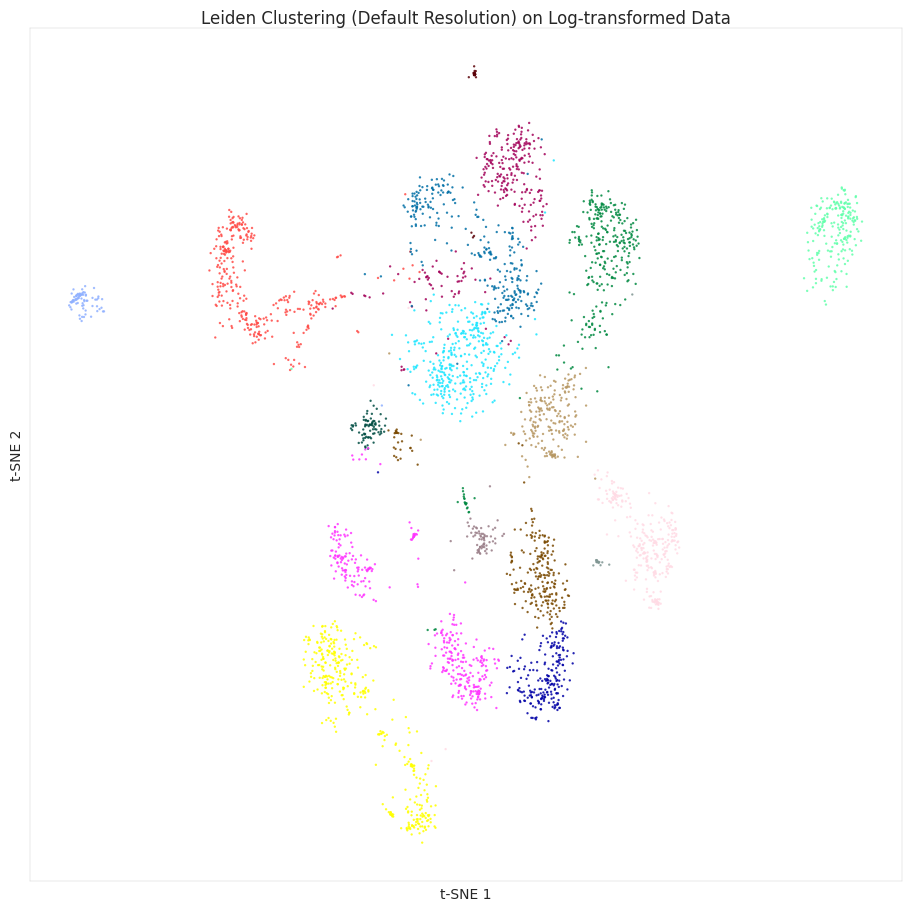

In [39]:
# --------------------------
# Plot the results (1 pt)
# --------------------------


fig, ax = plt.subplots(figsize=(9, 9))
ax.scatter(
    tsne_log[:, 0], tsne_log[:, 1], c=clusterCols[leiden_clusters], s=2, alpha=0.8
)
ax.set_title("Leiden Clustering (Default Resolution) on Log-transformed Data")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("../images/lab7-leiden_default.png", dpi=300, bbox_inches="tight")
plt.show()

### 2.4. Change the clustering resolution

The number of clusters can be changed by modifying the resolution parameter. How many clusters did we get with the default value? Change the resolution parameter to yield 2x more and 2x fewer clusters
Plot all three results as t-SNE overlays (same as above).

_(1.5 pts)_

In [40]:
# ------------------------------------------------------------------
# run the clustering for 3 different resolution parameters (0.5 pts)
# ------------------------------------------------------------------


# Default resolution is 1.0
partition_default = la.find_partition(
    g, la.RBConfigurationVertexPartition, resolution_parameter=1.0
)
leiden_clusters_default = partition_default.membership
print(
    f"Number of clusters with default resolution (1.0): {len(np.unique(leiden_clusters_default))}"
)

# 2x more clusters (resolution = 2.0)
partition_more = la.find_partition(
    g, la.RBConfigurationVertexPartition, resolution_parameter=2.0
)
leiden_clusters_more = partition_more.membership
print(f"Number of clusters with resolution 2.0: {len(np.unique(leiden_clusters_more))}")

# 2x fewer clusters (resolution = 0.5)
partition_fewer = la.find_partition(
    g, la.RBConfigurationVertexPartition, resolution_parameter=0.5
)
leiden_clusters_fewer = partition_fewer.membership
print(
    f"Number of clusters with resolution 0.5: {len(np.unique(leiden_clusters_fewer))}"
)

Number of clusters with default resolution (1.0): 17
Number of clusters with resolution 2.0: 22
Number of clusters with resolution 0.5: 12


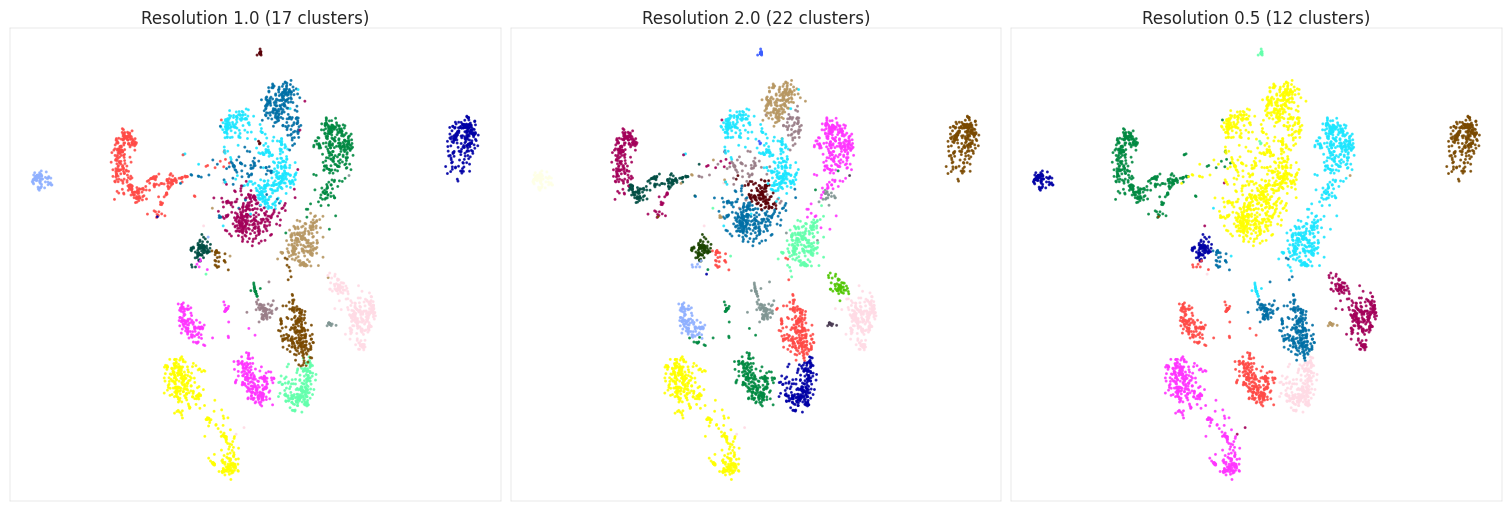

In [44]:
# --------------------------
# Plot the results (1 pt)
# --------------------------

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# add plot
axs[0].scatter(
    tsne_log[:, 0],
    tsne_log[:, 1],
    c=clusterCols[leiden_clusters_default],
    s=5,
    alpha=0.8,
)
axs[0].set_title(f"Resolution 1.0 ({len(np.unique(leiden_clusters_default))} clusters)")
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].scatter(
    tsne_log[:, 0], tsne_log[:, 1], c=clusterCols[leiden_clusters_more], s=5, alpha=0.8
)
axs[1].set_title(f"Resolution 2.0 ({len(np.unique(leiden_clusters_more))} clusters)")
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].scatter(
    tsne_log[:, 0], tsne_log[:, 1], c=clusterCols[leiden_clusters_fewer], s=5, alpha=0.8
)
axs[2].set_title(f"Resolution 0.5 ({len(np.unique(leiden_clusters_fewer))} clusters)")
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.savefig("../images/lab7-leiden_resolutions.png", dpi=300, bbox_inches="tight")
plt.show()